In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from sqlalchemy import create_engine
import pymysql
from pymysql.cursors import DictCursor
import pymysql.cursors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
username = 'root'          
password = ''               
host = 'localhost'         
port = '3306'              
database = 'top7_leagues' 

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [3]:
query = "SELECT * FROM match_events_2023_24"
df_events = pd.read_sql(query, engine)

In [4]:
query2 = "SELECT * FROM players_info_2023_24"
df_players = pd.read_sql(query2, engine)

In [5]:
df_teams = df_players[['team_id', 'team_name']].drop_duplicates()

## Adding xG Column

In [6]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
        
    # Goal center coordinates
    goal_x = 120
    goal_y = 40

    # Calculate shot distance & angle

    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots

In [7]:
def xG_calculation(df_shots):
    
    # Define features and target
    features = ['shot_distance', 'shot_angle_deg','is_penalty','x','y']
    target = 'is_goal'
    
    # Define feature matrix and target vector
    X = df_shots[features]
    y = df_shots[target]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = X_train  
    X_test_scaled = X_test
    
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    
    xgb_model.fit(X_train_scaled, y_train)
    
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Create a subset DataFrame with only the features required for prediction
    df_shots_numeric = df_shots[features]
    
    # Generate xG predictions based on the selected numeric columns
    xg_predictions = xgb_model.predict_proba(df_shots_numeric)[:, 1]  # Get probability for 'goal' (class 1)
    
    #Add the xG predictions back to the original DataFrame
    df_shots['xG'] = xg_predictions

    return df_shots

In [8]:
df_shots = transform_data(df_events)

In [9]:
df_shots = xG_calculation(df_shots)

In [11]:
df_shots.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_penalty,shot_distance,shot_angle_deg,xG
75,2602367713,1734766,41,4,13.0,60,370000,117.48,47.68,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,8.082871,71.834043,0.102411
217,2602380121,1734766,99,12,40.0,60,345908,97.32,41.92,NaN,...,1,0,0,SavedShot,Successful,FirstHalf,0,22.761125,4.838899,0.032292
296,2602385821,1734766,151,17,2.0,60,79840,110.04,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,10.888600,23.834263,0.171072
305,2602386809,1734766,158,17,56.0,60,79840,107.40,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,13.346160,19.249526,0.121244
395,2602392055,1734766,253,23,46.0,54,395188,108.12,22.88,NaN,...,1,0,0,ShotOnPost,Successful,FirstHalf,0,20.838157,55.242243,0.025924


In [12]:
df_events = pd.merge(df_events,df_shots[['id','xG']],on='id',how='left')
df_events['xG'].fillna(0, inplace=True)

In [13]:
df_events['own_goal'] = np.where((df_events['is_goal']==1) & (df_events['x']<30), 1,0)

In [15]:
df_events.columns

Index(['id', 'match_id', 'event_id', 'minute', 'second', 'team_id',
       'player_id', 'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'type_display_name',
       'outcome_type_display_name', 'period_display_name', 'xG', 'own_goal'],
      dtype='object')

In [16]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,xG,own_goal
0,2602361573,1734766,3,0,0.0,54,135366,60.12,40.00,55.68,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
1,2602361601,1734766,4,0,1.0,54,82989,55.32,40.24,38.28,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
2,2602361647,1734766,5,0,4.0,54,125211,38.16,69.52,24.96,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
3,2602361695,1734766,6,0,6.0,54,121456,24.96,55.36,24.12,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
4,2602361767,1734766,7,0,9.0,54,454342,23.28,28.64,21.72,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0


## Determine Match Scores

In [20]:
def score_per_game(df_events):
    goals_per_game = df_events.groupby(['match_id','team_id'])[['is_goal','own_goal','xG']].sum().reset_index()
    goals_per_game['is_goal'] = goals_per_game['is_goal']-goals_per_game['own_goal']
    
    goals_per_game['team_identifier'] = 'team_' + (goals_per_game.groupby('match_id').cumcount() + 1).astype(str)
    
    score_per_game = goals_per_game.pivot(index='match_id', columns='team_identifier', values=['team_id', 'is_goal', 'own_goal','xG'])
    
    score_per_game.columns = [f'{col[0]}_{col[1]}' for col in score_per_game.columns]
    
    score_per_game.reset_index(inplace=True)
    
    score_per_game.rename(columns={
        'team_id_team_1': 'team_1_id',
        'is_goal_team_1': 'team_1_goals',
        'own_goal_team_1': 'team_1_own_goals',
        'team_id_team_2': 'team_2_id',
        'is_goal_team_2': 'team_2_goals',
        'own_goal_team_2': 'team_2_own_goals',
    
    }, inplace=True)
    
    score_per_game['team_1_goals'] = score_per_game['team_1_goals'] + score_per_game['team_2_own_goals']
    score_per_game['team_2_goals'] = score_per_game['team_2_goals'] + score_per_game['team_1_own_goals']
    
    score_per_game.drop(columns=['team_1_own_goals', 'team_2_own_goals'], inplace=True)

    score_per_game = pd.merge(score_per_game, df_teams, left_on = 'team_1_id',right_on='team_id')
    score_per_game = pd.merge(score_per_game, df_teams, left_on = 'team_2_id',right_on='team_id')
    
    score_per_game = score_per_game[['match_id','team_1_id','team_2_id','team_name_x','team_name_y','team_1_goals','team_2_goals','xG_team_1','xG_team_2']]
    
    score_per_game.rename(columns={'team_name_x':'team_1_name','team_name_y':'team_2_name'},inplace=1)
        
    return score_per_game

In [21]:
score_per_game = score_per_game(df_events)

In [23]:
score_per_game

,match_id,team_1_id,team_2_id,team_1_name,team_2_name,team_1_goals,team_2_goals,xG_team_1,xG_team_2
0,1729190,13.0,174.0,Arsenal,Nottingham-Forest,2.0,1.0,1.165430,0.511499
1,1729454,13.0,174.0,Arsenal,Nottingham-Forest,2.0,1.0,1.665947,0.779480
2,1729293,167.0,174.0,Manchester-City,Nottingham-Forest,2.0,0.0,0.746141,0.823560
3,1729332,167.0,174.0,Manchester-City,Nottingham-Forest,2.0,0.0,1.251912,1.541531
4,1729247,29.0,174.0,West-Ham,Nottingham-Forest,3.0,2.0,1.826450,1.325815
...,...,...,...,...,...,...,...,...,...
2357,1748642,121.0,122.0,Rio-Ave,Boavista,0.0,0.0,0.682965,0.698023
2358,1748529,107.0,122.0,Vitoria-de-Guimaraes,Boavista,1.0,1.0,1.177720,1.652334
2359,1748611,107.0,122.0,Vitoria-de-Guimaraes,Boavista,1.0,0.0,0.900977,0.343449
2360,1748434,107.0,108.0,Vitoria-de-Guimaraes,Moreirense,0.0,1.0,0.728443,1.207838


In [24]:
def transform_columns_to_row(score_per_game):
    team_1_view = pd.DataFrame({
        'match_id': score_per_game['match_id'],
        'team_id': score_per_game['team_1_id'],           
        'team': score_per_game['team_1_name'],
        'goals_scored': score_per_game['team_1_goals'],
        'xG': score_per_game['xG_team_1'],            
        'opponent': score_per_game['team_2_name'],
        'goals_conceded': score_per_game['team_2_goals'],
        'xGA': score_per_game['xG_team_2'],
        'xG-xGA': score_per_game['xG_team_1'] - score_per_game['xG_team_2'],  
    })
    
    team_2_view = pd.DataFrame({
        'match_id': score_per_game['match_id'],
        'team_id': score_per_game['team_2_id'],           
        'team': score_per_game['team_2_name'],
        'goals_scored': score_per_game['team_2_goals'],
        'xG': score_per_game['xG_team_2'],            
        'opponent': score_per_game['team_1_name'],
        'goals_conceded': score_per_game['team_1_goals'],
        'xGA': score_per_game['xG_team_1'],
        'xG-xGA': score_per_game['xG_team_2'] - score_per_game['xG_team_1'],  
    })

    df_ml = pd.concat([team_1_view, team_2_view])

    return df_ml 

In [28]:
df_ml = transform_columns_to_row(score_per_game)

In [29]:
def calculate_points(team_goals, opponent_goals):
    if team_goals > opponent_goals:
        return 3  # win
    elif team_goals == opponent_goals:
        return 1  # draw
    else:
        return 0  # loss

In [30]:
df_ml['points'] = df_ml.apply(lambda row: calculate_points(row['goals_scored'], row['goals_conceded']), axis=1)

In [31]:
df_ml

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points
0,1729190,13.0,Arsenal,2.0,1.165430,Nottingham-Forest,1.0,0.511499,0.653931,3
1,1729454,13.0,Arsenal,2.0,1.665947,Nottingham-Forest,1.0,0.779480,0.886467,3
2,1729293,167.0,Manchester-City,2.0,0.746141,Nottingham-Forest,0.0,0.823560,-0.077420,3
3,1729332,167.0,Manchester-City,2.0,1.251912,Nottingham-Forest,0.0,1.541531,-0.289619,3
4,1729247,29.0,West-Ham,3.0,1.826450,Nottingham-Forest,2.0,1.325815,0.500635,3
...,...,...,...,...,...,...,...,...,...,...
2357,1748642,122.0,Boavista,0.0,0.698023,Rio-Ave,0.0,0.682965,0.015059,1
2358,1748529,122.0,Boavista,1.0,1.652334,Vitoria-de-Guimaraes,1.0,1.177720,0.474614,1
2359,1748611,122.0,Boavista,0.0,0.343449,Vitoria-de-Guimaraes,1.0,0.900977,-0.557528,0
2360,1748434,108.0,Moreirense,1.0,1.207838,Vitoria-de-Guimaraes,0.0,0.728443,0.479395,3


In [33]:
columns_to_sum = ['xG', 'goals_scored', 'goals_conceded', 'xGA','xG-xGA','points']  

# Group by 'team_id' and aggregate with 'first' for 'team_name'
df_ml_grouped = df_ml.groupby('team_id').agg({
    'team': 'first',  # Get the first team name
    **{col: 'sum' for col in columns_to_sum}  # Sum for other columns
}).reset_index()

# Now, sort by 'xG' in descending order
df_ml_grouped.sort_values(by='xG', ascending=False, inplace=True)

# Reset the index
df_ml_grouped.reset_index(drop=True, inplace=True)

In [35]:
df_ml_grouped.head()

,team_id,team,xG,goals_scored,goals_conceded,xGA,xG-xGA,points
0,129.0,PSV-Eindhoven,93.990016,111.0,21.0,27.103748,66.886269,91
1,26.0,Liverpool,87.206499,86.0,41.0,41.785881,45.420617,82
2,256.0,Feyenoord,84.632837,92.0,26.0,20.358860,64.273978,84
3,13.0,Arsenal,79.229722,91.0,29.0,30.360062,48.869660,89
4,37.0,Bayern-Munich,79.097444,94.0,45.0,33.502255,45.595189,72


<Axes: xlabel='xG', ylabel='points'>

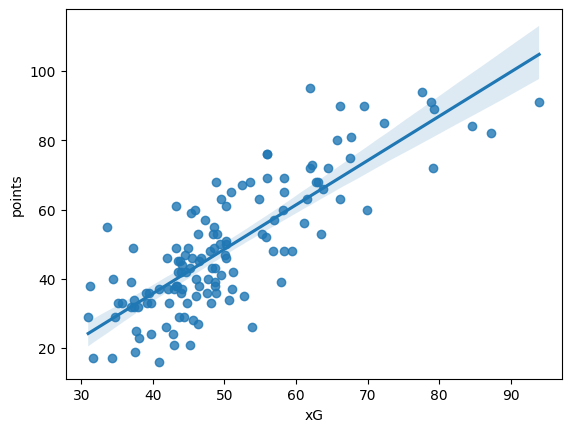

In [40]:
sns.regplot(data = df_ml_grouped ,x ='xG',y='points')

<Axes: xlabel='xG', ylabel='xGA'>

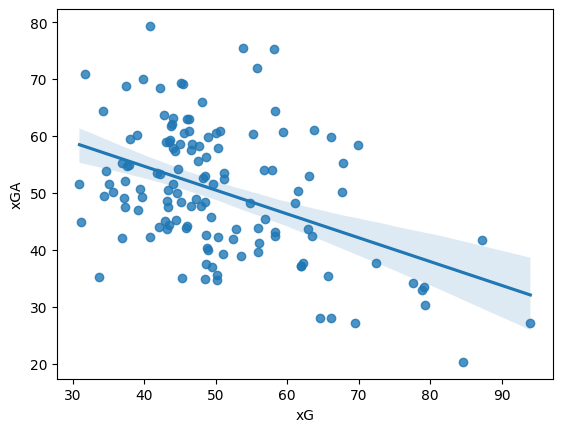

In [41]:
sns.regplot(data = df_ml_grouped ,x ='xG',y='xGA')